# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [2]:
# import cudf as pd
import pandas as pd
import numpy as np

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [3]:
tracks = pd.read_parquet('tracks.parquet')
catalog_names = pd.read_parquet('catalog_names.parquet')
interactions = pd.read_parquet('interactions.parquet')

# Обзор данных
Проверяем данные, есть ли с ними явные проблемы.

In [4]:
display(tracks.sample(5))
tracks.dtypes

,track_id,albums,artists,genres
858451,69610141,[11673151],[452221],"[17, 25]"
300755,19363775,[2181612],[3147354],"[47, 154]"
545825,37696904,"[4784480, 4784938]",[42528],[50]
926420,79856727,[14560182],[10931140],"[11, 20]"
897904,74796137,[13103055],[9361974],"[44, 75]"


track_id     int64
albums      object
artists     object
genres      object
dtype: object

In [5]:
display(catalog_names.sample(5))
display(catalog_names.dtypes)
catalog_names.type.value_counts()

,id,type,name
1557420,56306361,track,I Dont Care
1144104,21579433,track,Swing Thing (Re-Swing)
160855,2618877,album,Love Playlist
397158,7361839,album,Girls Wanna Love
609294,16989636,album,Swing & Duck


id       int64
type    object
name    object
dtype: object

type
track     1000000
album      658724
artist     153581
genre         166
Name: count, dtype: int64

In [6]:
catalog_names.type = catalog_names.type.astype('category')
catalog_names.dtypes

id         int64
type    category
name      object
dtype: object

In [7]:
display(interactions.sample(5))
interactions.dtypes

,user_id,track_id,track_seq,started_at
47,399755,280509,48,2022-07-23
455,970554,78588376,456,2022-07-26
81,1273475,796798,82,2022-09-22
105,224525,14298571,106,2022-07-18
158,1053310,14641839,159,2022-11-07


user_id                int32
track_id               int32
track_seq              int16
started_at    datetime64[ns]
dtype: object

In [8]:
# все трэки есть в catalog_names
tracks.track_id.isin(catalog_names[catalog_names.type=='track'].id).nunique()

1

Есть ли треки с неизвестными исполнителями, альбомами, жанрами?

In [9]:
%%time
import multiprocessing as mp
albums = catalog_names[catalog_names.type=='album']
albums_ids = np.array(albums.id.values.tolist())
def check_albums(track_items):
    return True in [item_id in albums_ids for item_id in track_items]
with mp.Pool(mp.cpu_count()) as pool:
    tracks['albums_ok'] = pool.map(check_albums, tracks.albums)
tracks.albums_ok.value_counts()

CPU times: user 3.09 s, sys: 2.23 s, total: 5.32 s
Wall time: 37 s


albums_ok
True     999982
False        18
Name: count, dtype: int64

In [10]:
%%time
genres = catalog_names[catalog_names.type=='genre']
genres_ids = np.array(genres.id.values.tolist())
def check_genres(track_items):
    return True in [item_id in genres_ids for item_id in track_items]
with mp.Pool(mp.cpu_count()) as pool:
    tracks['genres_ok'] = pool.map(check_genres, tracks.genres)
tracks.genres_ok.value_counts()

CPU times: user 1.54 s, sys: 2.61 s, total: 4.14 s
Wall time: 4.42 s


genres_ok
True     996306
False      3694
Name: count, dtype: int64

In [11]:
%%time
artists = catalog_names[catalog_names.type=='artist']
artists_ids = np.array(artists.id.values.tolist())
def check_artists(track_items):
    return True in [item_id in artists_ids for item_id in track_items]
with mp.Pool(mp.cpu_count()) as pool:
    tracks['artists_ok'] = pool.map(check_artists, tracks.artists)
tracks.artists_ok.value_counts()

CPU times: user 2.08 s, sys: 2.24 s, total: 4.33 s
Wall time: 5.1 s


artists_ok
True     984631
False     15369
Name: count, dtype: int64

In [25]:
%%time
# Удаление
# print(tracks.shape[0])
tracks = tracks.query("artists_ok==True and albums_ok==True and genres_ok==True")
# print(tracks.shape[0])
# print(interactions.shape[0])
interactions = interactions[interactions.track_id.isin(tracks.track_id)]
# print(interactions.shape[0])

980970
980970
CPU times: user 4.06 s, sys: 390 ms, total: 4.45 s
Wall time: 4.52 s


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

В catalog_names поле type было преобразовано в категорию;
Найдено 18 трэков у которых ни один из альбомов не присутствует в catalog_names;
Найдено 3694 трэка у которых ни один из жанров не присутствует в catalog_names;
Найдено 15369 трэков у которых ни один из артистов не присутствует в catalog_names;

Удалять их необязательно?

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

array([[<Axes: title={'center': 'track_id'}>]], dtype=object)

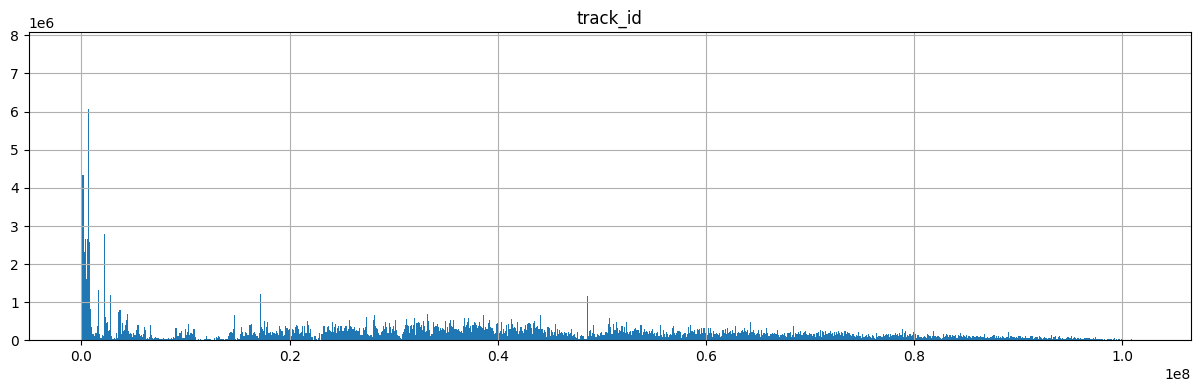

In [14]:
interactions.hist(column='track_id', bins=1000, figsize=(15,4))

In [72]:
top10tracks = tracks[tracks.track_id.isin(interactions.track_id.value_counts()[:10].index)]

Наиболее популярные треки

In [145]:
tracks_catalog = catalog_names[catalog_names.type=='track']
top10tracks_catalog = tracks_catalog[tracks_catalog.id.isin(top10tracks.track_id)]
top10tracks_catalog = top10tracks_catalog.rename({'id': 'track_id'}, axis=1)
def get_list(df, ids):
    return ', '.join(df[df.id.isin(ids)].name)
top10tracks['artists_names'] = top10tracks.apply(lambda row: get_list(artists, row.artists), axis=1)
top10tracks['genres_names'] = top10tracks.apply(lambda row: get_list(genres, row.genres), axis=1)
top10tracks.merge(top10tracks_catalog, on='track_id')[['track_id', 'artists_names', 'name', 'genres_names']]

/tmp/ipykernel_251231/1969510382.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10tracks['artists_names'] = top10tracks.apply(lambda row: get_list(artists, row.artists), axis=1)
/tmp/ipykernel_251231/1969510382.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10tracks['genres_names'] = top10tracks.apply(lambda row: get_list(genres, row.genres), axis=1)


,track_id,artists_names,name,genres_names
0,53404,Nirvana,Smells Like Teen Spirit,"alternative, rock, allrock"
1,178529,Linkin Park,Numb,"numetal, metal"
2,795836,Sting,Shape Of My Heart,"pop, rock, allrock"
3,24692821,KALEO,Way Down We Go,indie
4,32947997,Ed Sheeran,Shape of You,pop
5,33311009,Imagine Dragons,Believer,"rock, allrock"
6,35505245,"Рем Дигга, Miyagi & Эндшпиль",I Got Love,"rusrap, rap"
7,45499814,Zivert,Life,"pop, ruspop"
8,51241318,"Tommee Profitt, Fleurie, Mellen Gi",In The End,rnb
9,65851540,Dabro,Юность,"pop, ruspop"


Наиболее популярные жанры

In [151]:
# cм выше

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22
...,...,...,...,...
287,1374582,95514767,288,2022-12-29
288,1374582,97220301,289,2022-12-29
289,1374582,97241171,290,2022-12-29
290,1374582,98542641,291,2022-12-29


Треки, которые никто не прослушал

In [150]:
tracks[~tracks.track_id.isin(interactions.track_id)]
# таких нет

,track_id,albums,artists,genres,albums_ok,genres_ok,artists_ok


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

# Топ популярных

Рассчитаем рекомендации как топ популярных.

# Персональные

Рассчитаем персональные рекомендации.

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.